# Lane Image Processing

This notebook deal with processing the images for finding lane lines and their curvatures

## Pipeline for threholding images based on color channel, magnitude and direction of gradient

This section will deal with the two provided straight lines images and try to find lanes lines in them. And plot it as required. Once done, this same pipeline will be tested on all test images.

In [1]:
# importing all the libraries required in this file
import cv2
import numpy as np
import matplotlib as mp
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import pickle
from matplotlib.path import Path
import matplotlib.patches as patches

from random import randint

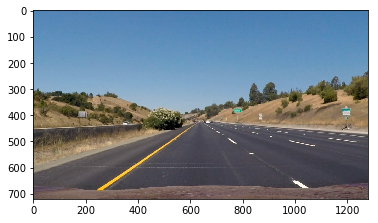

In [2]:
# First image - straight_lines1.jpg
sl1_img = mpimg.imread('test_images\straight_lines1.jpg')
plt.imshow(sl1_img)
plt.show()

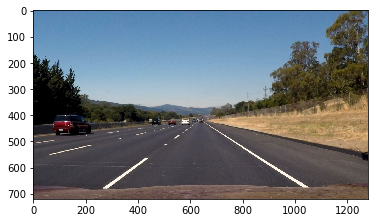

In [3]:
# Second image - straight_lines2.jpg
sl2_img = mpimg.imread('test_images\straight_lines2.jpg')
plt.imshow(sl2_img)
plt.show()

### Methods related to gradient mag, direction, sobel x, and sobel y:

In [4]:

# appliying direction gradient on the image in x-axis
def performSobelX(image, sobel_kernal=3):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernal)
    
# appliying direction gradient on the image in y-axis
def performSobelY(image, sobel_kernal=3):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernal)
    
# applying the threshold on directional gradient
def createBinaryImageWithSobelGradient(image, axis='x', sobel_kernal=3, min_thresh=10, max_thresh=100):
    
    if axis is 'x':
        abs_sobel = np.absolute(performSobelX(image, sobel_kernal))
    else:
        abs_sobel = np.absolute(performSobelY(image, sobel_kernal))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(scaled_sobel >= min_thresh) & (scaled_sobel < max_thresh)] = 1
    
    return s_binary
    
# applying the threshold on the magnitude of the gradient
def performGradientMagnitudeThreshold(image, axis='x', sobel_kernal=3, mag_thresh=(0,255)):

    gradmag = None
    if axis is 'x':
        sobelx = performSobelX(image, sobel_kernal)
        gradmag = np.sqrt(sobelx**2)
    elif axis is 'y':
        sobely = performSobelY(image, sobel_kernal)
        gradmag = np.sqrt(sobely**2)
    elif axis is 'xy':
        sobelx = performSobelX(image)
        sobely = performSobelY(image)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
    else:
        return null
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output
    
# applying threshold on the direction of the gradient
def performGradientDirectionThreshold(image, sobel_kernal=3, dir_thresh=(0, np.pi/2)):
    
    sobelx = performSobelX(image, sobel_kernal)
    sobley = performSobelY(image, sobel_kernal)
    
    absgraddir = np.arctan(np.absolute(sobely), np.absolute(sobelx))
    binary_img = np.zeros_like(absgraddir)
    binary_img[(absgraddir >= dir_thresh[0]) & (absgraddir < dir_thresh[1])] = 1
    
    return binary_img
    

In [5]:
# ploting two image side by side
def plot_images(img1, img2, title1, title2):
    plt.clf()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

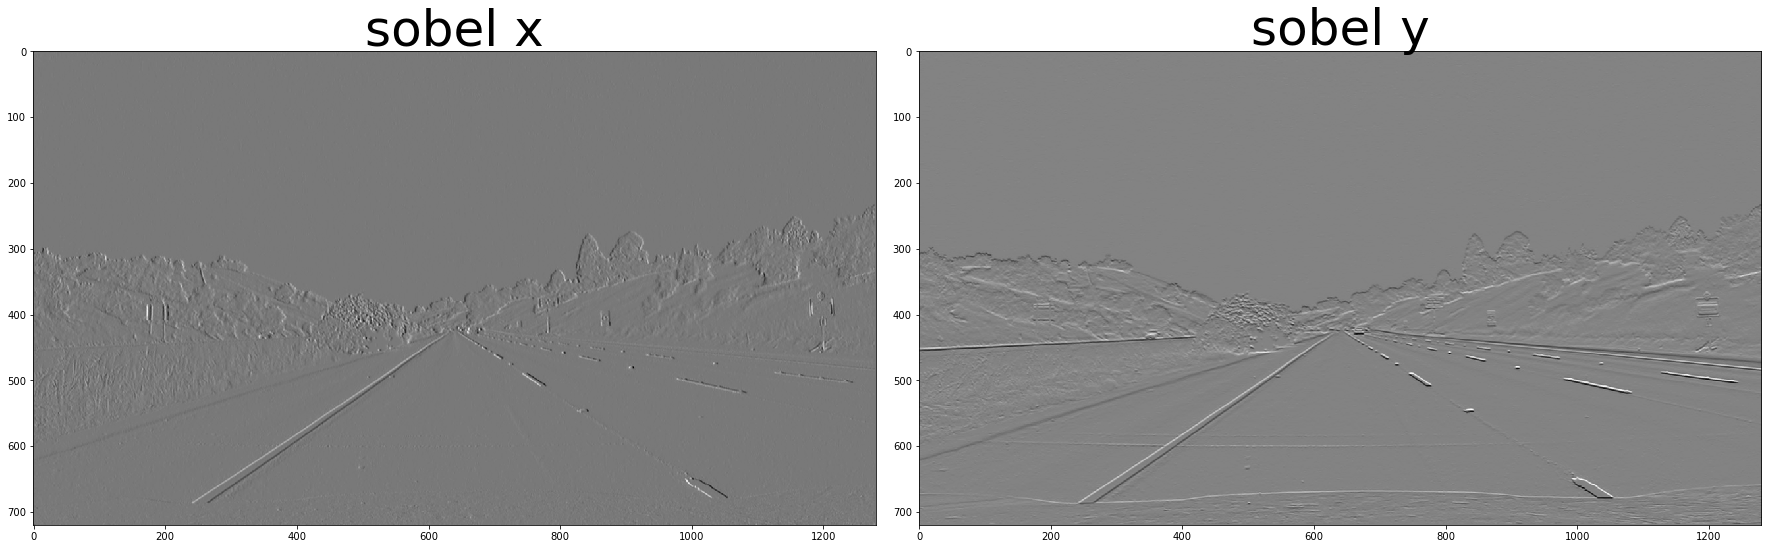

In [6]:
# experimenting with different thresholds
sobelx = performSobelX(sl1_img)
sobely = performSobelY(sl1_img)
plot_images(sobelx, sobely, 'sobel x', 'sobel y')

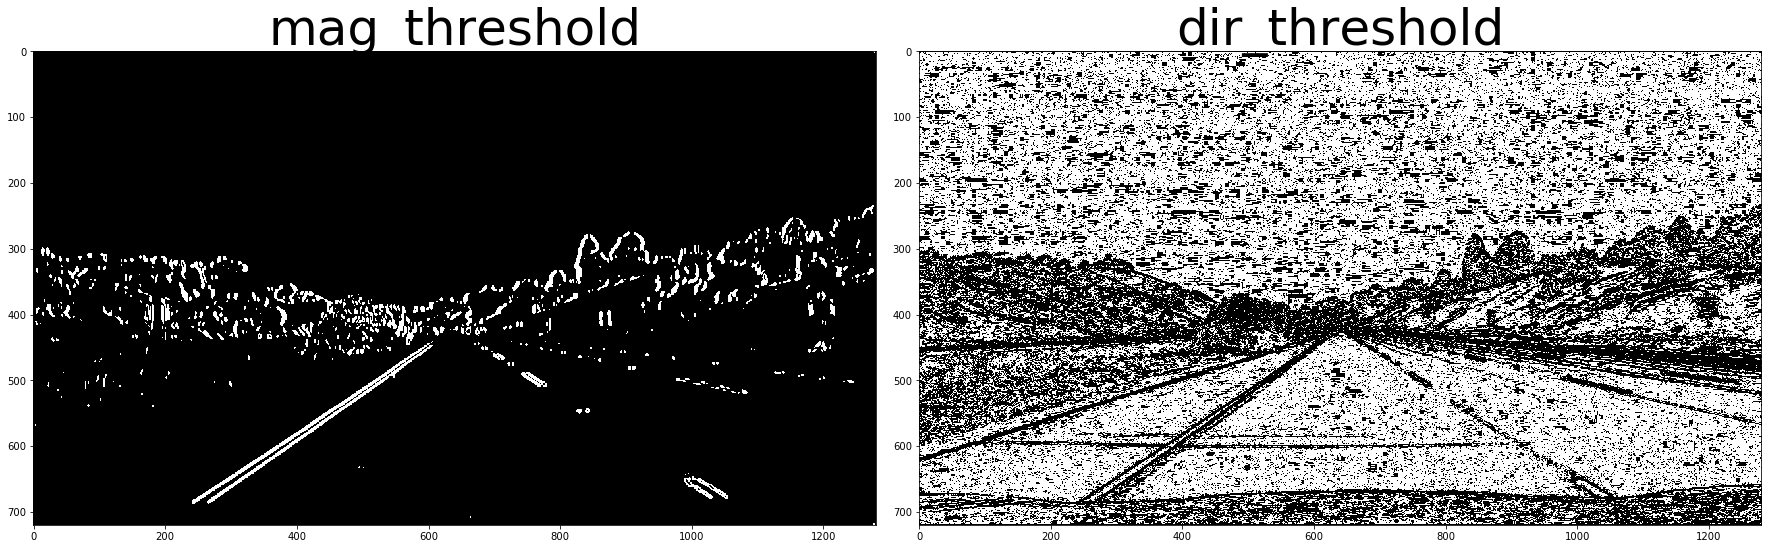

In [7]:
# experimenting with thresholding gradient magnitude and direction
sobel_kernal = 15
mag_binary = performGradientMagnitudeThreshold(sl1_img, 'x', sobel_kernal=sobel_kernal, mag_thresh=(40,160))
dir_binary = performGradientDirectionThreshold(sl1_img, sobel_kernal=sobel_kernal, dir_thresh=(0.7,1.5))
plot_images(mag_binary, dir_binary, 'mag_threshold', 'dir_threshold')

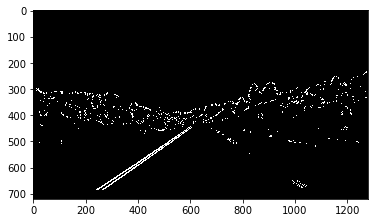

In [8]:
# combining all thersholds
gradx = createBinaryImageWithSobelGradient(sl1_img, 'x', sobel_kernal, min_thresh=40, max_thresh=160)
grady = createBinaryImageWithSobelGradient(sl1_img, 'y', sobel_kernal, min_thresh=40, max_thresh=160)

combined_binary = np.zeros_like(dir_binary)
combined_binary[((gradx == 1) & ( grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined_binary, cmap='gray')
plt.show()

In [9]:
# method to return the s-channel binary for given images
def hls_threshold(image, thresh=(0,255)):
    hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls_img[:,:,2]
    output = np.zeros_like(s)
    output[(s > thresh[0]) & (s <= thresh[1])] = 1
    return output

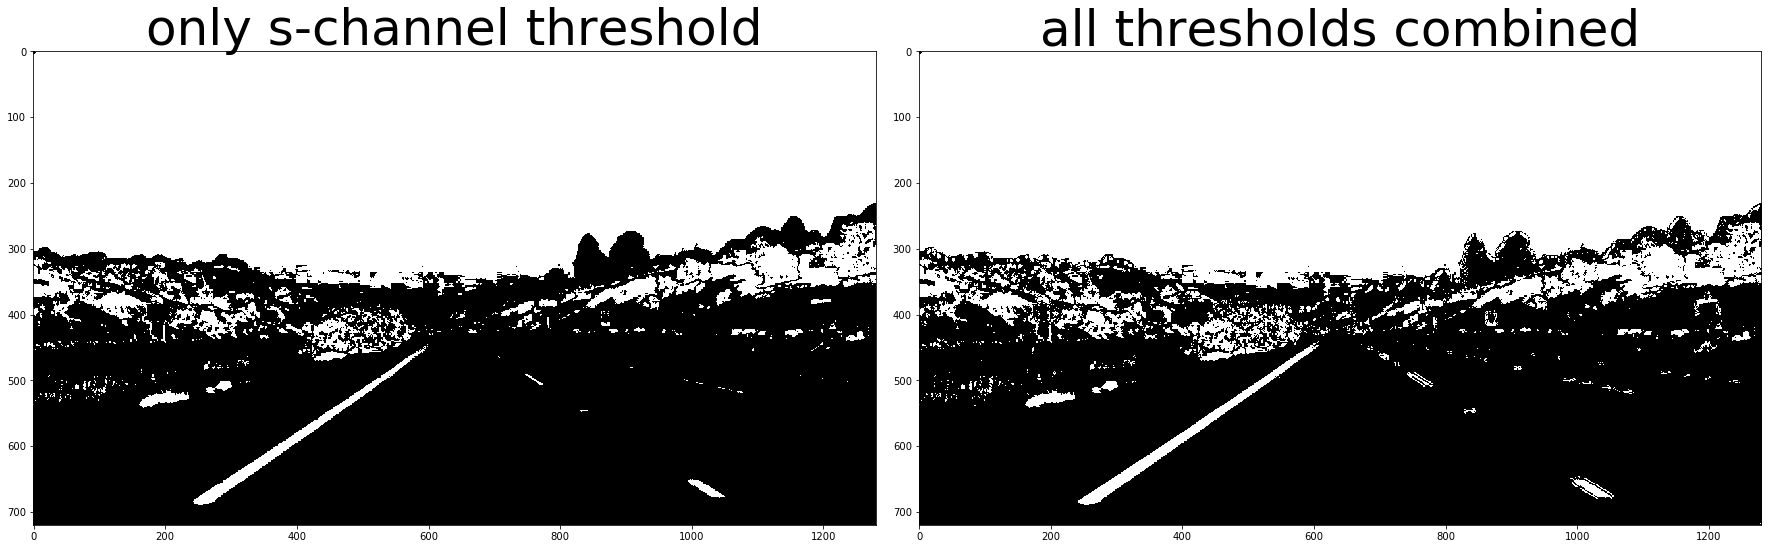

In [10]:
s = hls_threshold(sl1_img, thresh=(80,255))

# comnbining s channel image with all other thresholds
all_combined = np.zeros_like(combined_binary)
all_combined[(combined_binary == 1) | (s == 1)] = 1

plot_images(s, all_combined, 'only s-channel threshold', 'all thresholds combined')

### Pipeline for perspective transform on lane images

This section will take the lane images and apply perspective transform on top to it to get a bird-eye perspective image

In [11]:
def cal_undistort(orig_img, objpoints, imgpoints):
    gray_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_img.shape[::-1], None, None)
    undist = cv2.undistort(orig_img, mtx, dist, None, mtx)
    return undist

In [12]:
# load object and image points from disk which have been saved from
# performing camera calibration with given chessboard images
obj_points = []
img_points = []
with open('obj_img_points.pickle', 'rb') as handle:
    a = pickle.load(handle)
    obj_points = a['objpoints']
    img_points = a['imgpoints']

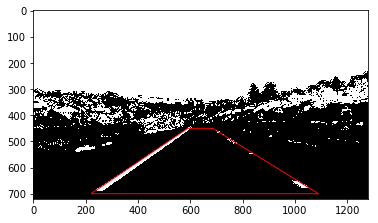

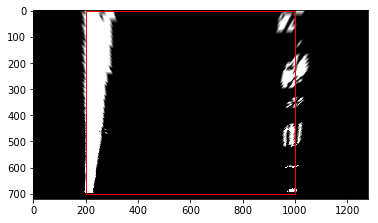

In [13]:
# defining the source and destination points for perspective transform
test_img = mpimg.imread('test_images\straight_lines1.jpg')
img_size = (test_img.shape[1], test_img.shape[0])
undistored = cal_undistort(test_img, obj_points, img_points)
gray = cv2.cvtColor(undistored, cv2.COLOR_RGB2GRAY)

src = np.float32([(220,700), (590,450), (685,450), (1090,700)])
dst = np.float32([(200,700), (200,0), (1000,0), (1000,700)])

src_copy = np.float32([(200,700), (600,450), (700,450), (1100,700)])
line = plt.Polygon(src, fill=None, edgecolor='r')
plt.imshow(all_combined, cmap='gray')
plt.gca().add_line(line)
plt.show()

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(all_combined, M, img_size)
line2 = plt.Polygon(dst, fill=None, edgecolor='r')
plt.imshow(warped, cmap='gray')
plt.gca().add_line(line2)
plt.show()

### Finding lane lines and distinguishing right lane from left

This section will create pipeline for finding lanes lines and how to better distinguish right lane lines from left lane lines

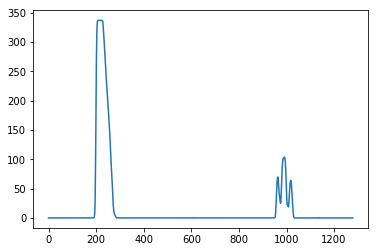

In [14]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

In [15]:
# implementing sliding window algo and fitting a polynomial

def performSlidingWindowSearch(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='red')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.imshow(warped, cmap='gray')
    plt.show()


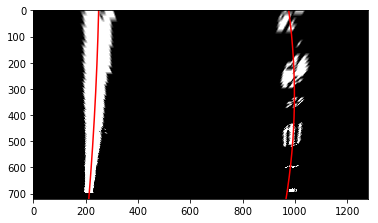

In [16]:
performSlidingWindowSearch(warped)

In [17]:
# Get radius of curvature
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

NameError: name 'ploty' is not defined

In [ ]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = cv2.getPerspectiveTransform(dst, src)
newwarp = cv2.warpPerspective(color_warp, Minv, (sl1_img.shape[1], sl1_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistored, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()